# Multi-armed bandit
### Thompson sampling with success probability constraint and stochastic rewards

In [1]:
from matplotlib import pyplot as plt

import numpy as np
import ray
import time

from source import simluate_rayleigh_fading_channel
from source import ThompsonSamplingBandit, OuterLoopLinkAdaptation

plt.rcParams.update({'font.size': 22, 'lines.linewidth' : 3})

ray_redis_address = "10.0.0.5:15672"
ray.init(address=ray_redis_address, ignore_reinit_error=True, log_to_driver=False)

2020-02-14 00:24:00,470	WARNING worker.py:682 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.


{'node_ip_address': '10.0.0.5',
 'object_store_address': '/tmp/ray/session_2020-02-13_23-13-46_710474_26220/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-02-13_23-13-46_710474_26220/sockets/raylet',
 'redis_address': '10.0.0.5:15672',
 'session_dir': '/tmp/ray/session_2020-02-13_23-13-46_710474_26220',
 'webui_url': None}

In [2]:
@ray.remote
def f():
    time.sleep(0.01)
    return ray.services.get_node_ip_address()

# Get a list of the IP addresses of the nodes that have joined the cluster.
ray_node_ips = set(ray.get([f.remote() for _ in range(1000)]))
print('Number of active Ray nodes: %d'%(len(ray_node_ips)))

Number of active Ray nodes: 2


# Load Offline Model

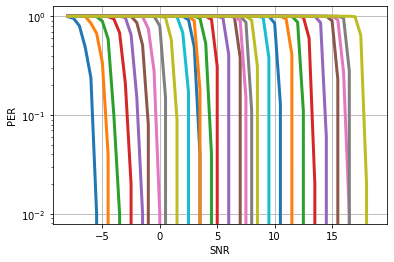

In [3]:
#awgn_datafile = 'AWGN_CUSTOM_CONFIG_DATAFILE.npy'
#awgn_data = np.load( awgn_datafile, encoding='latin1', allow_pickle=True )[ ( ) ]

awgn_datafile = 'AWGN_DATASET.npy'
awgn_data = np.load( awgn_datafile, allow_pickle=True )[ ( ) ]

snr_vs_per = awgn_data['snr_vs_per']
snr_range_dB = awgn_data['snr_range_dB']

#ignore_rate_indices = []#[0, 9, 15, 19, 20, 21]
#snr_vs_per = np.delete(snr_vs_per, ignore_rate_indices, 1)

nrof_snr, nrof_rates = snr_vs_per.shape

plt.figure()
plt.grid(True)
for i in range(nrof_rates):
    plt.semilogy(snr_range_dB, snr_vs_per[:, i])
plt.xlabel( 'SNR' )
plt.ylabel( 'PER')
    
plt.show()

In [4]:
#packet_sizes = [ 20, 20, 40, 64, 84, 104, 124, 148, 168, 148, 188, 232, 272, 316, 356, 400, 408, 472, 536, 900, 660, 724 ]
#packet_sizes = [r for i, r in enumerate(packet_sizes) if i not in ignore_rate_indices]

packet_sizes = [152, 200, 248, 320, 408, 504, 600, 712, 808, 936, 
                936, 1032, 1192, 1352, 1544, 1736, 1800, 
                1800, 1928, 2152, 2344, 2600, 2792, 2984, 3240, 3496, 3624, 3752, 4008]

modorders    = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
                4, 4, 4, 4, 4, 4, 4, 
                6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

target_per = 0.1
cqi_delay = 32

In [5]:
#code_rates = [p / (72 * 12 * m ) * 1024 for p, m in zip( packet_sizes, modorders) ]
#print( [(i, m, c) for i, m, c in zip( range( len(modorders)) , modorders, code_rates)] )
#REF_MCS_INDICES = [0, 1, 3, 5, 8, 9, 11, 14, 16, 20, 22, 24, 27, 28, 28]

In [6]:
#from source import determine_cqi_from_sinr

#cqi = []
#for s in snr_range_dB:
#    cqi.append( determine_cqi_from_sinr(s, packet_sizes, awgn_data) )
    
#plt.plot( snr_range_dB, cqi )
#plt.xlabel('Instantaneous SNR [dB]')
#plt.ylabel('CQI')

In [7]:
@ray.remote
def run_experiment( seed, nrof_ttis = 500, cqi_delay = 0, avg_snr_dB = 20  ):
    
    from source import estimate_sinr_from_cqi, determine_per_at_sinr, simluate_rayleigh_fading_channel
    from source import OracleConstrainedBandit, ThompsonSamplingBandit, OuterLoopLinkAdaptation

    packet_error_probabilities, channel_quality_indices = simluate_rayleigh_fading_channel( nrof_ttis, 
                                                                                            avg_snr_dB, 
                                                                                            awgn_data, 
                                                                                            packet_sizes, 
                                                                                            norm_doppler = 0.1, 
                                                                                            seed = seed )

    # Pre-generate ACK events for all rates for all channel samples
    packet_acks = np.ndarray( ( nrof_ttis, nrof_rates ) )
    for tti in range( nrof_ttis ):
        for rate_index in range( nrof_rates ):
            packet_acks[tti, rate_index] = np.random.uniform( ) > packet_error_probabilities[tti, rate_index]

    # Thompson Sampling
    ts_bandit = ThompsonSamplingBandit(nrof_rates, packet_sizes, target_per)
    #ts_bandit = OuterLoopLinkAdaptationNew(nrof_rates, packet_sizes, awgn_data, target_per, olla_step_size=0.1)
    
    ts_rates  = [] 
    ts_acks  = []
    ts_tputs = []
    for tti in range( nrof_ttis ):
        
        # Skip the first few samples to account for CQI delay
        if tti < cqi_delay:
            continue
            
        cqi = channel_quality_indices[tti]
        selected_rate_index = ts_bandit.act( cqi )

        ack = packet_acks[tti, selected_rate_index]
        ts_bandit.update( selected_rate_index, cqi, ack )

        ts_rates.append( selected_rate_index )
        ts_acks.append( ack )
        ts_tputs.append( packet_sizes[ selected_rate_index ] * ack )
    
    
    
    # Outer Loop Link Adaptation
    olla_bandit = OuterLoopLinkAdaptation(nrof_rates, packet_sizes, awgn_data, target_per, olla_step_size=0.3)
    
    olla_rates  = []
    olla_acks  = []
    olla_tputs = []
    for tti in range( nrof_ttis ):
        
        # Skip the first few samples to account for CQI delay
        if tti < cqi_delay:
            continue
            
        cqi = channel_quality_indices[tti]    
        selected_rate_index = olla_bandit.act( cqi )

        ack = packet_acks[tti, selected_rate_index]
        olla_bandit.update( selected_rate_index, cqi, ack )

        olla_rates.append(selected_rate_index)
        olla_acks.append(ack)
        olla_tputs.append( packet_sizes[ selected_rate_index ] * ack )
    
    return ( ts_rates, ts_acks, ts_tputs, olla_rates, olla_acks, olla_tputs)

In [8]:
ts_mcs = []
ts_ack = []
ts_tput = []

olla_mcs = []
olla_ack = []
olla_tput = []

results = ray.get( [ run_experiment.remote( seed = i ) for i in range(256) ] )

for res in results:
    ts_mcs.append( res[0] )
    ts_ack.append( res[1] )
    ts_tput.append( res[2] )
    
    olla_mcs.append( res[3] )
    olla_ack.append( res[4] )
    olla_tput.append( res[5] )

2020-02-14 00:24:09,508	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4183, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:09,510	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4183, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,512	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_

2020-02-14 00:24:10,531	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4181, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,538	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4183, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,539	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_

2020-02-14 00:24:10,568	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4182, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,569	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4181, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,570	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_

2020-02-14 00:24:10,597	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4183, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,598	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4181, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,599	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_

2020-02-14 00:24:10,626	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4180, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,627	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4180, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,628	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_

2020-02-14 00:24:10,659	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4183, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,660	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4182, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,661	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_

2020-02-14 00:24:10,687	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4180, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,688	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4182, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,690	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_

2020-02-14 00:24:10,713	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4183, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,715	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4182, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,717	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_

2020-02-14 00:24:10,748	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4180, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,749	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4183, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,751	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_

2020-02-14 00:24:10,783	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4182, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,784	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4181, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,786	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_

2020-02-14 00:24:10,814	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4181, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,816	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4183, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,818	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_

2020-02-14 00:24:10,860	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4180, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,863	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4182, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,866	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_

2020-02-14 00:24:10,912	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4182, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,915	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4183, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,919	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_

2020-02-14 00:24:10,958	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4180, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,960	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_worker (pid=4182, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'
2020-02-14 00:24:10,962	ERROR worker.py:1003 -- Possible unhandled error from worker: ray_

RayTaskError(KeyError): [36mray_worker[39m (pid=4183, ip=10.0.0.19)
  File "python/ray/_raylet.pyx", line 640, in ray._raylet.execute_task
  File "<ipython-input-7-2365401429be>", line 12, in run_experiment
  File "/home/ubuntu/workspace/rate-selection-per-constraint/source.py", line 112, in simluate_rayleigh_fading_channel
    _, nrof_rates = awgn_data['snr_vs_bler'].shape
KeyError: 'snr_vs_bler'

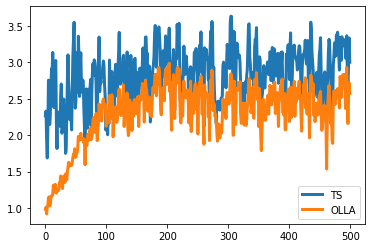

In [9]:
plt.plot(np.mean(np.array(ts_tput)[:, :] / (72 * 15), axis=0))
plt.plot(np.mean(np.array(olla_tput)[:, :] / (72 * 15), axis=0))

plt.legend(['TS', 'OLLA'])

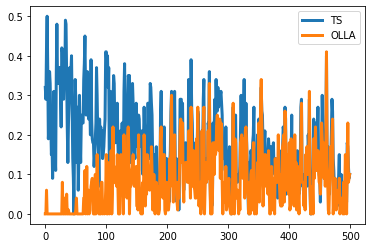

In [10]:
plt.plot(1.0 - np.mean(np.array(ts_ack)[:, :], axis=0))
plt.plot(1.0 - np.mean(np.array(olla_ack)[:, :], axis=0))

plt.legend(['TS', 'OLLA'])

In [10]:
plt.plot(ts_rate_indices)

NameError: name 'ts_rate_indices' is not defined

In [15]:
olla_bandit = OuterLoopLinkAdaptation(nrof_rates, packet_sizes, awgn_data, target_per)

In [16]:
olla_tput = []
olla_rate_indices = []
for sample_index in range( nrof_samples ):
    cqi = channel_quality_indices[sample_index]
    selected_rate_index = olla_bandit.act( cqi )
    
    ack = packet_acks[sample_index, selected_rate_index]
    olla_bandit.update( selected_rate_index, cqi, ack )
    
    olla_tput.append( packet_sizes[ selected_rate_index ] * ack )
    olla_rate_indices.append( selected_rate_index )

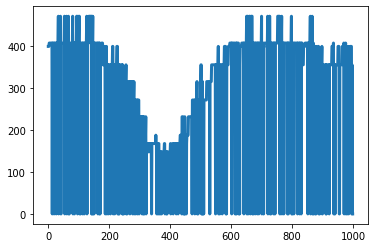

In [17]:
plt.plot(olla_tput)

In [19]:
print(np.sum(olla_tput))
print(np.sum(ts_tput))

296120.0
240076.0


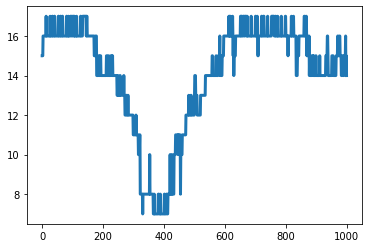

In [18]:
plt.plot(olla_rate_indices[:])

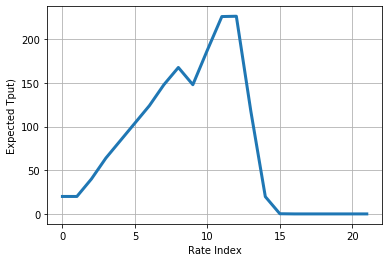

In [14]:
expected_tputs = [ (1-per) * psize for per, psize in zip( packet_error_probabilities[100,:], packet_sizes )]

plt.figure()
plt.grid(True)
plt.plot(expected_tputs)

plt.xlabel('Rate Index')
plt.ylabel('Expected Tput)')
plt.show()

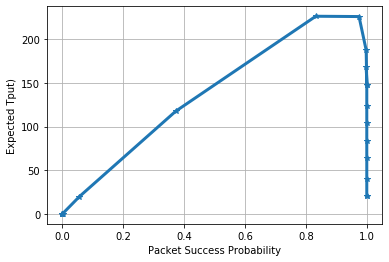

In [19]:
plt.figure()
plt.grid(True)
plt.plot(1.0 - packet_error_probabilities[100,:], expected_tputs, '-*')

plt.xlabel('Packet Success Probability')
plt.ylabel('Expected Tput)')
plt.show()

In [9]:
@ray.remote # Comment out this line to run locally
def run_experiment(policy, T, play_result, packet_sizes):
    outcome = np.zeros((T, 2))
    for t in range(T):    
        rate_index = policy.act()
        ack = play_result[t][rate_index]

        outcome[t, 0] = ack
        
        if ack:
            outcome[t, 1] = packet_sizes[rate_index]
        
        policy.update(rate_index, ack)
        
    return outcome

In [8]:
def play(policy, T, N, play_result, packet_sizes, name):
    start = time.time()
    
    # Uncomment the following line to run locally
    #outcome = [run_experiment(policy, T, play_result[n], packet_sizes) for n in range(N)]
    outcome = ray.get([run_experiment.remote(policy, T, play_result[n], packet_sizes) for n in range(N)])
        
    total_acks = np.zeros((T))
    total_tput = np.zeros((T))
    for n in range(N):
        total_acks += outcome[n][:, 0]
        total_tput += outcome[n][:, 1]
    
    print(name + ' done! Elasped: %0.2fs'%(time.time() - start))
    
    return (total_acks / N, total_tput / N)

In [9]:
T = 1000
N = 48

# Generate all events in advance
np.random.seed(42)
env = Environment( packet_error_ratios )

#play_result = [[[env.pull(rate_index, t) for rate_index in range(nrof_rates)] for t in range(T)] for _ in range(N)]

true_per, cqi = simluate_rayleigh_fading_channel( nrof_samples, 
                                                  avg_snr_dB, 
                                                  awgn_data, 
                                                  packet_sizes, 
                                                  norm_doppler = 0.01, 
                                                  seed = 9999 ):

oracle_avg_success, oracle_avg_reward = play( OracleConstrainedBandit(nrof_rates,
                                                                      packet_sizes,  
                                                                      target_per,
                                                                      env_instance=env), 
                                              T, 
                                              N, 
                                              play_result, 
                                              packet_sizes, 
                                              'Oracle' )

con_ts_avg_success, con_ts_avg_reward = play( ThompsonSamplingBandit(nrof_rates,
                                                                     packet_sizes,
                                                                     target_per), 
                                        T, 
                                        N, 
                                        play_result, 
                                        packet_sizes,
                                        'Con-TS' )

# Informed Priors
cqi = max(np.argwhere(packet_error_ratios <= 0.1))[0]
estimated_sinr = estimate_sinr_from_cqi(cqi, awgn_data)
est_per = determine_per_at_sinr(estimated_sinr, awgn_data)
prior = [(1.0 - b) for b in est_per]
    
con_ts_infp_avg_success, con_ts_infp_avg_reward = play( ThompsonSamplingBandit(nrof_rates,
                                                                               packet_sizes,
                                                                               target_per,
                                                                               prior_success_mean=prior), 
                                              T, 
                                              N, 
                                              play_result, 
                                              packet_sizes,
                                              'Con-TS-Infp' )

# Outer Loop Link Adaptation
olla_avg_success, olla_avg_reward = play( OuterLoopLinkAdaptation( nrof_rates, 
                                                                   packet_sizes,
                                                                   awgn_data,
                                                                   target_per,
                                                                   cqi=cqi), 
                                                      T, 
                                                      N, 
                                                      play_result, 
                                                      packet_sizes,
                                                      'OLLA' )


Oracle done! Elasped: 142.38s
Con-TS done! Elasped: 151.12s
Con-TS-Infp done! Elasped: 146.06s
OLLA done! Elasped: 23.82s


In [10]:
data = {'oracle_avg_success': oracle_avg_success,
        'oracle_avg_reward': oracle_avg_reward,
        'con_ts_avg_success': con_ts_avg_success,
        'con_ts_avg_reward': con_ts_avg_reward,
        'con_ts_infp_avg_success': con_ts_infp_avg_success,
        'con_ts_infp_avg_reward': con_ts_infp_avg_reward,
        'olla_avg_success': olla_avg_success,
        'olla_avg_reward': olla_avg_reward,
        'target_success_prob': 1.0 - target_per,
 #       'success_prob': success_prob,
        'T': T,
        'N': N}

#filename = 'RESULTS/RESULTS_OLLA_%ddB.npy'%(int(snr_level))
#np.save(filename, data)

# Non-stationary Environment

In [16]:
T = 1000
N = 100

success_prob_1 = 1.0 - snr_vs_bler[32, :]  # 6 dB
success_prob_2 = 1.0 - snr_vs_bler[38, :]  # 9 dB
success_prob_3 = 1.0 - snr_vs_bler[44, :]  # 12 dB

# Generate all events in advance
np.random.seed(42)
env = Environment([success_prob_1, success_prob_2, success_prob_3], True, 250)

play_result = [[[env.pull(arm, t) for arm in range(nrof_arms)] for t in range(T)] for _ in range(N)]

solvers.options['show_progress'] = False

oracle_avg_success, oracle_avg_reward = play( OracleConstrainedBandit(nrof_arms,
                                                                      reward_value,  
                                                                      target_success_prob,
                                                                      env_instance=env), 
                                              T, 
                                              N, 
                                              play_result, 
                                              reward_value, 
                                              'Oracle' )

con_ts_avg_success, con_ts_avg_reward = play( ThompsonSamplingBandit(nrof_arms,
                                                                     reward_value,
                                                                     target_success_prob,
                                                                     window_size=100), 
                                        T, 
                                        N, 
                                        play_result, 
                                        reward_value,
                                        'Con-TS' )

# Informed Priors
cqi = max(np.argwhere(success_prob >= 0.9))[0]
estimated_sinr = estimate_sinr_from_cqi(cqi)
bler = determine_bler_at_sinr(estimated_sinr)
prior = [(1.0 - b) for b in bler]
    
con_ts_infp_avg_success, con_ts_infp_avg_reward = play( ThompsonSamplingBandit(nrof_arms,
                                                                               reward_value,
                                                                               target_success_prob,
                                                                               window_size=100,
                                                                               prior_success_mean=prior), 
                                                      T, 
                                                      N, 
                                                      play_result, 
                                                      reward_value,
                                                      'Con-TS-Infp' )

# Outer Loop Link Adaptation
olla_avg_success, olla_avg_reward = play( OuterLoopLinkAdaptation( nrof_arms, 
                                                                   reward_value,
                                                                   target_success_prob,
                                                                   window_size=100,
                                                                   cqi=cqi), 
                                                                  T, 
                                                                  N, 
                                                                  play_result, 
                                                                  reward_value,
                                                                  'OLLA' )



Oracle done! Elasped: 368.83s
Con-TS done! Elasped: 354.47s
Con-TS-Infp done! Elasped: 352.17s
OLLA done! Elasped: 331.47s


In [17]:
data = {'oracle_avg_success': oracle_avg_success,
        'oracle_avg_reward': oracle_avg_reward,
        'con_ts_avg_success': con_ts_avg_success,
        'con_ts_avg_reward': con_ts_avg_reward,
        'con_ts_infp_avg_success': con_ts_infp_avg_success,
        'con_ts_infp_avg_reward': con_ts_infp_avg_reward,
        'olla_avg_success': olla_avg_success,
        'olla_avg_reward': olla_avg_reward,
        'target_success_prob': target_success_prob,
 #       'success_prob': success_prob,
        'T': T,
        'N': N}

filename = 'RESULTS/RESULTS_OLLA_NONSTATIONARY.npy'
np.save(filename, data)

# Load and plot stuff

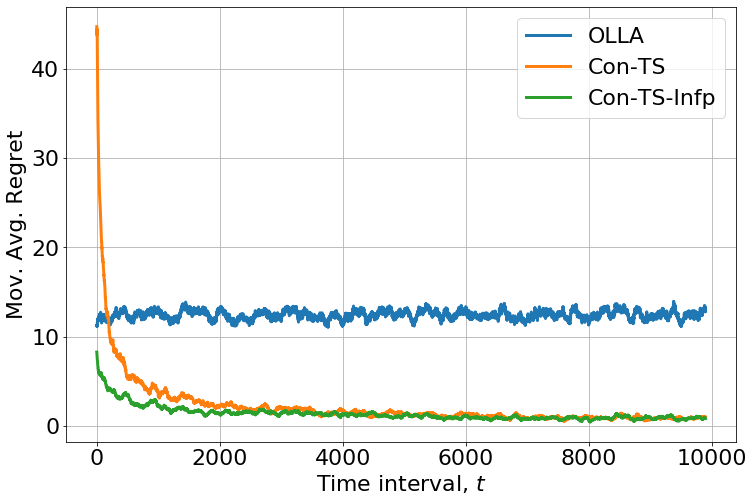

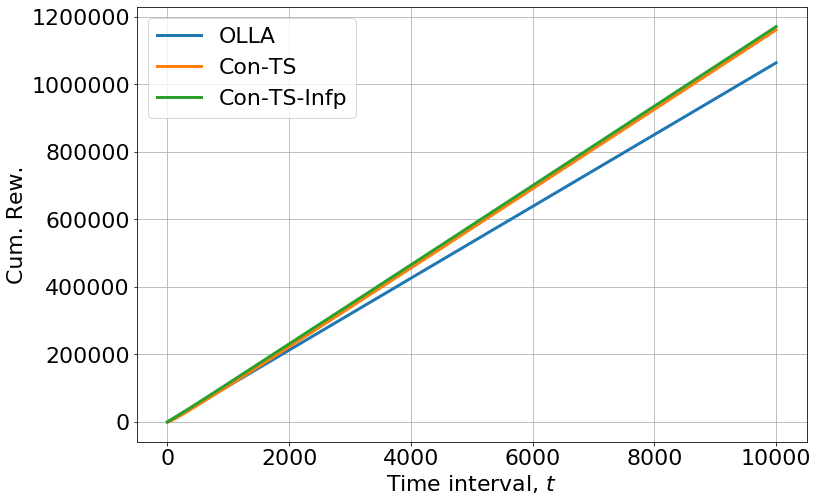

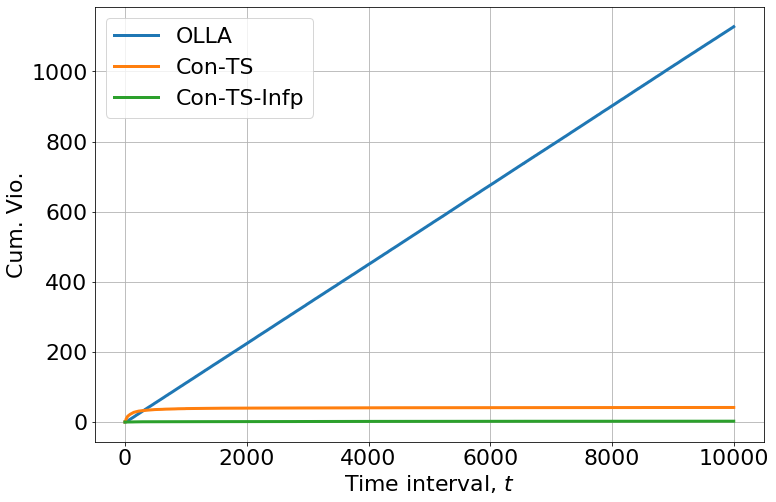

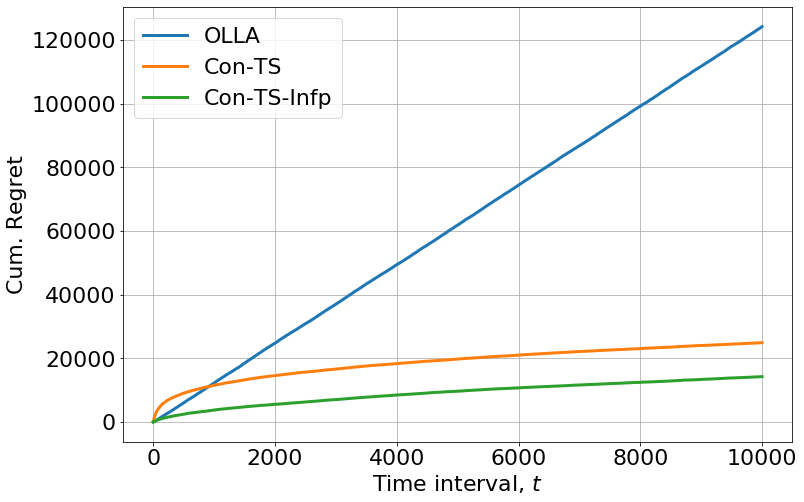

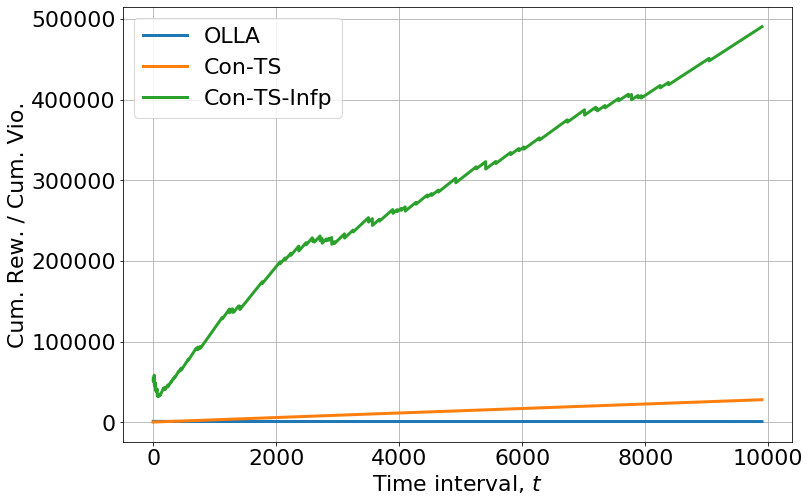

In [12]:
plt.rcParams.update({'font.size': 22, 'lines.linewidth' : 3})

olla_cum_reward = np.cumsum(data['olla_avg_reward'])
con_ts_cum_reward= np.cumsum(data['con_ts_avg_reward'])
con_ts_infp_cum_reward = np.cumsum(data['con_ts_infp_avg_reward'])
oracle_cum_reward = np.cumsum(data['oracle_avg_reward'])

def movavg(cumsum, win_size=100):
    return (cumsum[win_size:] - cumsum[:-1 * win_size]) / win_size
                             
olla_cum_vio = np.cumsum(np.maximum(0.0, 1.0 - target_per - data['olla_avg_success']))
con_ts_cum_vio = np.cumsum(np.maximum(0.0, 1.0 - target_per - data['con_ts_avg_success']))
con_ts_infp_cum_vio = np.cumsum(np.maximum(0.0, 1.0 - target_per - data['con_ts_infp_avg_success']))

olla_cum_regret = np.cumsum(np.maximum(0.0, data['oracle_avg_reward'] - data['olla_avg_reward']))
con_ts_cum_regret= np.cumsum(np.maximum(0.0, data['oracle_avg_reward'] - data['con_ts_avg_reward']))
con_ts_infp_cum_regret = np.cumsum(np.maximum(0.0, data['oracle_avg_reward'] - data['con_ts_infp_avg_reward']))

# Mov. Avg. Regret
plt.figure(figsize=[12, 8])
plt.grid(True)

plt.plot(movavg(olla_cum_regret))
plt.plot(movavg(con_ts_cum_regret))
plt.plot(movavg(con_ts_infp_cum_regret))

plt.legend(['OLLA', 'Con-TS', 'Con-TS-Infp'])
plt.xlabel('Time interval, $t$')
plt.ylabel('Mov. Avg. Regret')

plt.show()

# Cum. Rew.
plt.figure(figsize=[12, 8])
plt.grid(True)

plt.plot(olla_cum_reward)
plt.plot(con_ts_cum_reward)
plt.plot(con_ts_infp_cum_reward)

plt.legend(['OLLA', 'Con-TS', 'Con-TS-Infp'])
plt.xlabel('Time interval, $t$')
plt.ylabel('Cum. Rew.')

plt.show()

# Cum. Vio.
plt.figure(figsize=[12, 8])
plt.grid(True)

plt.plot(olla_cum_vio)
plt.plot(con_ts_cum_vio)
plt.plot(con_ts_infp_cum_vio)

plt.legend(['OLLA', 'Con-TS', 'Con-TS-Infp'])
plt.xlabel('Time interval, $t$')
plt.ylabel('Cum. Vio.')

plt.show()

# Cum. Regret
plt.figure(figsize=[12, 8])
plt.grid(True)

plt.plot(olla_cum_regret)
plt.plot(con_ts_cum_regret)
plt.plot(con_ts_infp_cum_regret)

plt.legend(['OLLA', 'Con-TS', 'Con-TS-Infp'])
plt.xlabel('Time interval, $t$')
plt.ylabel('Cum. Regret')

plt.show()

# Cum. Rew. / Cum. Vio.
plt.figure(figsize=[12, 8])
plt.grid(True)

offset = 100
plt.plot(np.divide(olla_cum_reward[offset:], olla_cum_vio[offset:]))
plt.plot(np.divide(con_ts_cum_reward[offset:], con_ts_cum_vio[offset:]))
plt.plot(np.divide(con_ts_infp_cum_reward[offset:], con_ts_infp_cum_vio[offset:]))

plt.legend(['OLLA', 'Con-TS', 'Con-TS-Infp'])
plt.xlabel('Time interval, $t$')
plt.ylabel('Cum. Rew. / Cum. Vio.')

plt.show()

Text(0, 0.5, 'Average Reward Events  $E[x_{k(t)}]$')

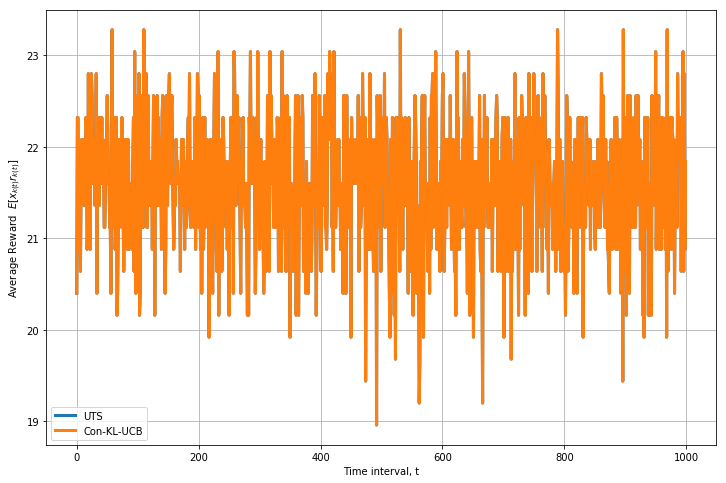

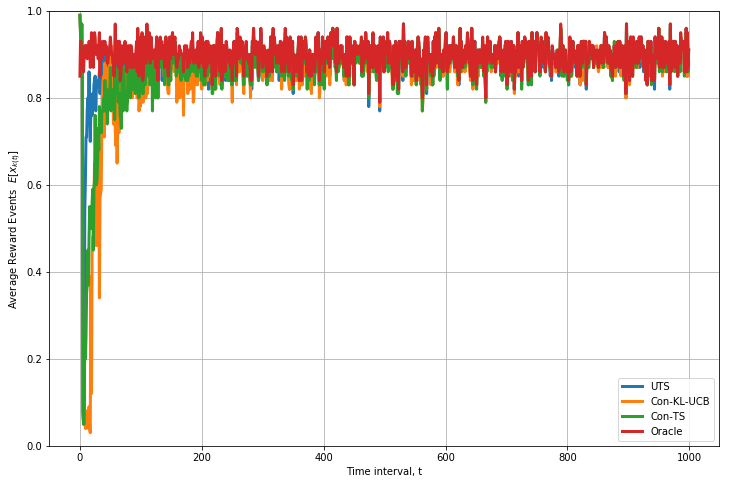

In [51]:
plt.figure(figsize=[12, 8])
plt.grid(True)

#plt.plot(data['uts_avg_reward'])
#plt.plot(data['con_kl_ucb_avg_reward'])
#plt.plot(data['con_ts_avg_reward'])
plt.plot(oracle1_avg_reward)
plt.plot(data['oracle_avg_reward'])

plt.legend(['UTS', 'Con-KL-UCB', 'Con-TS', 'Oracle'])

#plt.ylim([0.0, 1])
plt.xlabel('Time interval, t')
plt.ylabel('Average Reward  $E[x_{k(t)}r_{k(t)}]$')


plt.figure(figsize=[12, 8])
plt.grid(True)

plt.plot(data['uts_avg_success'])
plt.plot(data['con_kl_ucb_avg_success'])
plt.plot(data['con_ts_avg_success'])
plt.plot(data['oracle_avg_success'])

plt.legend(['UTS', 'Con-KL-UCB', 'Con-TS', 'Oracle'])

plt.ylim([0, 1])
plt.xlabel('Time interval, t')
plt.ylabel('Average Reward Events  $E[x_{k(t)}]$')